<h1 align=center> Transfer Learning with TensorFlow Hub for Disaster Tweet Prediction</h1>

---

# Overview

[TensorFlow Hub](https://tfhub.dev/) is a repository of pre-trained TensorFlow models.

In this project, we leverage the power of transfer learning by harnessing pre-trained models available in TensorFlow Hub, seamlessly integrated with the versatile tf.keras library. The primary focus of this project is text classification, a fundamental task in natural language processing (NLP). Transfer learning plays a pivotal role in this endeavor, allowing us to optimize resource utilization and attain exceptional model performance, even when working with limited training data.

Here's a more detailed breakdown of the key components of our project:

1. **Transfer Learning with TensorFlow Hub**: We tap into the wealth of pre-trained models available in TensorFlow Hub. These models have been meticulously trained on large and diverse datasets, gaining a deep understanding of language, semantics, and context. By utilizing these pre-trained models as our foundation, we can significantly reduce the amount of training data and resources required, making our project more efficient and accessible.

2. **Text Classification with tf.keras.**: The chosen framework for building and training our text classification model is tf.keras, an integral part of TensorFlow. tf.keras simplifies the process of model creation, training, and evaluation. This powerful library empowers us to seamlessly integrate the pre-trained models from TensorFlow Hub into our text classification task.

3. **Demonstrating the Power of Transfer Learning.**: Throughout the project, we emphasize the remarkable advantages of transfer learning. It enables our model to generalize effectively, even when working with a relatively small dataset. By fine-tuning the pre-trained models on our specific task, we showcase how transfer learning boosts performance and makes efficient use of computational resources.


*Note: This notebook is used only to explore the various trained models and compare them inorder to choose and select the best suited model for the data. This notebook is by no means used to submit scores in the Kaggle Natural Language Process with Disaster Tweets competition.*
 

# Project Initialization

Start your project by importing the necessary libraries and initializing your environment. Make sure to select a GPU Accelerator

In [1]:
import numpy as np
import pandas as pd

import tensorflow as tf
import tensorflow_hub as hub
import tensorflow_datasets as tfds

import matplotlib.pyplot as plt
plt.rcParams['figure.figsize'] = (12, 8)
from  IPython import display

import pathlib
import shutil
import tempfile

# Install additional packages
!pip install -q git+https://github.com/tensorflow/docs

import tensorflow_docs as tfdocs
import tensorflow_docs.modeling
import tensorflow_docs.plots

print("Version: ", tf.__version__)
print("Hub version: ", hub.__version__)
print("GPU is", "available" if tf.config.list_physical_devices('GPU') else "NOT AVAILABLE")

logdir = pathlib.Path(tempfile.mkdtemp())/"tensorboard_logs"
shutil.rmtree(logdir, ignore_errors=True)

/opt/conda/lib/python3.10/site-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.23.5
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


Version:  2.12.0
Hub version:  0.12.0
GPU is available


In [2]:
!nvidia-smi

Tue Oct 17 17:22:12 2023       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 470.161.03   Driver Version: 470.161.03   CUDA Version: 11.4     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla T4            Off  | 00000000:00:04.0 Off |                    0 |
| N/A   56C    P8    10W /  70W |      3MiB / 15109MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
|   1  Tesla T4            Off  | 00000000:00:05.0 Off |                    0 |
| N/A   

# Data Loading and Exploration

Loading the training data and explore its shape and the first few rows.

In [3]:
df = pd.read_csv('/kaggle/input/nlp-getting-started/train.csv')
df.shape

(7613, 5)

In [4]:
df.head()

,id,keyword,location,text,target
0,1,NaN,NaN,Our Deeds are the Reason of this #earthquake M...,1
1,4,NaN,NaN,Forest fire near La Ronge Sask. Canada,1
2,5,NaN,NaN,All residents asked to 'shelter in place' are ...,1
3,6,NaN,NaN,"13,000 people receive #wildfires evacuation or...",1
4,7,NaN,NaN,Just got sent this photo from Ruby #Alaska as ...,1


## Data Visualization

Lets visualize the distribution of the 'target' column.

<Axes: title={'center': 'Target'}, ylabel='Frequency'>

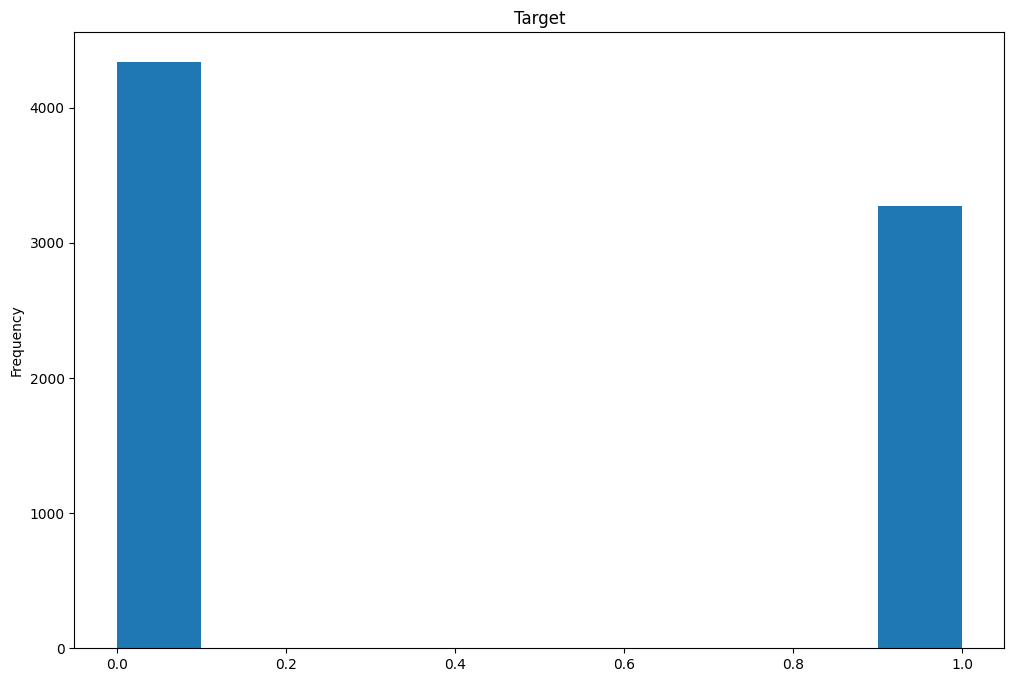

In [5]:
df['target'].plot(kind ='hist', title = 'Target')

*Note: Value = 1 (Real Disaster) , Value = 0 (Not a Disaster)*

## Data Splitting

Split your data into training and validation sets.

*Note: Feel free to experiment with smaller training sizes (0.001 - 0.01) to compare differences.*

In [6]:
from sklearn.model_selection import train_test_split
train_df, remaining = train_test_split(df, random_state =42, train_size = 0.2, stratify = df.target.values)
valid_df, _ = train_test_split(remaining, random_state=42, train_size = 0.1, stratify = remaining.target.values)
train_df.shape, valid_df.shape

((1522, 5), (609, 5))

## Data Sample

Display a sample of the 'target' and 'text' columns.

In [7]:
train_df.target.head(15).values
train_df.text.head(15)

5255    Watch our video of Wendell Berry speaking abou...
4653    @tonymcguinness probably being inundated with ...
825      My mic and controllers aren't working one second
6656    RT AbbsWinston: #Zionist #Terrorist kidnapped ...
1225    saving babies from burning buildings soaking c...
2682    Ignition Knock (Detonation) Sensor-Senso Stand...
2542           My Chemical Romance ÛÓ Desolation Row #np
4280    Have you heard Û÷05 LOVE TO LOVE YOU....HEAT ...
4691    Latest: Landslide kills three near Venice afte...
3257    Why tf did I decide to workout today? My body ...
2070    @GailSimone #IWasDisappointedBy TellTale's The...
2815    @Youssefyamani add Fez weather to the equation...
1799    Please keep Josh the Salyers/Blair/Hall famili...
5895    Watch This Airport Get Swallowed Up By A Sands...
1199    @themagickidraps not upset with a rally upset ...
Name: text, dtype: object

# Choose a TensorFlow Hub Module

Select a TensorFlow Hub module for your NLP model.

*Use the links below to copy different NLP models from TF Hub.*

In [8]:
#"https://tfhub.dev/google/tf2-preview/gnews-swivel-20dim/1", 
#"https://tfhub.dev/google/tf2-preview/nnlm-en-dim50/1", 
#"https://tfhub.dev/google/tf2-preview/nnlm-en-dim128/1", 
#"https://tfhub.dev/google/universal-sentence-encoder/4", 
#"https://tfhub.dev/google/universal-sentence-encoder-large/5"] {allow-input: true}

## Define and Train the Model

Define the model architecture and train it. 

*Use this helper function to train and evaluate your model of choice.*

In [9]:
def train_and_evaluate_model(module_url, embed_size, name, trainable=False):
  hub_layer = hub.KerasLayer(module_url, input_shape =[], output_shape =[embed_size], dtype = tf.string, trainable =trainable)
  model = tf.keras.models.Sequential([
      hub_layer,
      tf.keras.layers.Dense(256, activation = 'relu'),
      tf.keras.layers.Dense(64, activation ='relu'),
      tf.keras.layers.Dense(1, activation ='sigmoid')
  ])
  model.compile(optimizer= tf.keras.optimizers.Adam(learning_rate=0.0001),
                loss= tf.losses.BinaryCrossentropy(),
                metrics=[tf.metrics.BinaryAccuracy(name='accuracy')])
  model.summary()
  history = model.fit(train_df['text'],train_df['target'],
                      epochs =100,
                      batch_size=32,
                      validation_data = (valid_df['text'],valid_df['target']),
                      callbacks = [tfdocs.modeling.EpochDots(),
                                   tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=2, mode='min'),
                                   tf.keras.callbacks.TensorBoard(logdir/name)],
                      verbose=0)
  return history

## Train the Model

Train the model using the chosen module and specify the module's parameters.

We create a dictionary "histories" to store the keys and values which will be useful for plotting later during comparision. 

In [10]:
histories = {}

---

### gnews-swivel-20dim

The "gnews-swivel-20dim" is a pre-trained word embedding model available through TensorFlow Hub. Here's a brief overview:

- **Model Name:** gnews-swivel-20dim
- **Dimension:** 20
- **Type:** Word Embedding

#### Description

The "gnews-swivel-20dim" model is a word embedding model designed for natural language processing (NLP) tasks. It maps words or phrases to 20-dimensional vectors, capturing the semantic meaning and contextual relationships of words within a vast corpus of text.

#### Use Cases

- Text Classification
- Sentiment Analysis
- Named Entity Recognition
- Semantic Similarity Tasks
- And More

#### Key Features

- Compact 20-Dimensional Word Representations
- Pre-trained on a Large Text Corpus
- Effective for Various NLP Tasks
- Integrates with TensorFlow and Keras

*Note: Make sure to select the embed_size to 20*

In [11]:
module_url = "https://tfhub.dev/google/tf2-preview/gnews-swivel-20dim/1" 
histories['gnews-swivel-20dim'] = train_and_evaluate_model(module_url, embed_size=20, name='gnews-swivel-20dim', trainable=False)

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 keras_layer (KerasLayer)    (None, 20)                400020    
                                                                 
 dense (Dense)               (None, 256)               5376      
                                                                 
 dense_1 (Dense)             (None, 64)                16448     
                                                                 
 dense_2 (Dense)             (None, 1)                 65        
                                                                 
Total params: 421,909
Trainable params: 21,889
Non-trainable params: 400,020
_________________________________________________________________

Epoch: 0, accuracy:0.6360,  loss:0.6497,  val_accuracy:0.7307,  val_loss:0.6081,  
......................

---

### gnews-swivel-20dim-finetuned

We train the first layer by setting trainable = true. 

*Note: Make sure to select the embed_size to 20. Computation will take longer than previous one*

In [12]:
module_url = "https://tfhub.dev/google/tf2-preview/gnews-swivel-20dim/1" 
histories['gnews-swivel-20dim-finetuned'] = train_and_evaluate_model(module_url, embed_size=20, name='gnews-swivel-20dim-finetuned', trainable=True)

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 keras_layer_1 (KerasLayer)  (None, 20)                400020    
                                                                 
 dense_3 (Dense)             (None, 256)               5376      
                                                                 
 dense_4 (Dense)             (None, 64)                16448     
                                                                 
 dense_5 (Dense)             (None, 1)                 65        
                                                                 
Total params: 421,909
Trainable params: 421,909
Non-trainable params: 0
_________________________________________________________________

Epoch: 0, accuracy:0.6130,  loss:0.6409,  val_accuracy:0.7061,  val_loss:0.5952,  
.....................

---

### nnlm-en-dim50

The "nnlm-en-dim50" is a pre-trained word embedding model available through TensorFlow Hub. Here's a brief overview:

- **Model Name:** nnlm-en-dim50
- **Dimension:** 50
- **Type:** Word Embedding

#### Description

The "nnlm-en-dim50" model is a word embedding model that maps words or phrases to high-dimensional vectors. In this specific model, each word is represented as a 50-dimensional vector. These vectors capture the semantic meaning of words and their relationships within a vast corpus of text.

#### Use Cases

- Text Classification
- Natural Language Processing (NLP) Tasks
- Semantic Analysis

#### Key Features

- Efficient Word Representations
- Pre-trained on a Large Corpus
- Semantic Information Capture
- Usable as Input for Neural Networks

*Note: Make sure to select the embed_size to 50. Computation will take longer than previous one*

In [13]:
module_url = "https://tfhub.dev/google/tf2-preview/nnlm-en-dim50/1"
histories['nnlm-en-dim50'] = train_and_evaluate_model(module_url, embed_size=50, name='nnlm-en-dim50', trainable=False)

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 keras_layer_2 (KerasLayer)  (None, 50)                48190600  
                                                                 
 dense_6 (Dense)             (None, 256)               13056     
                                                                 
 dense_7 (Dense)             (None, 64)                16448     
                                                                 
 dense_8 (Dense)             (None, 1)                 65        
                                                                 
Total params: 48,220,169
Trainable params: 29,569
Non-trainable params: 48,190,600
_________________________________________________________________

Epoch: 0, accuracy:0.5907,  loss:0.6744,  val_accuracy:0.6273,  val_loss:0.6616,  
....................

---

### nnlm-en-dim128

The "nnlm-en-dim128" is a pre-trained word embedding model available through TensorFlow Hub. Here's a brief overview:

- **Model Name:** nnlm-en-dim128
- **Dimension:** 128
- **Type:** Word Embedding

#### Description

The "nnlm-en-dim128" model is a word embedding model designed for natural language processing (NLP) tasks. It maps words or phrases to 128-dimensional vectors, capturing the rich semantic meaning and contextual relationships of words within a vast corpus of text.

#### Use Cases

- Text Classification
- Semantic Analysis
- Named Entity Recognition
- Language Generation
- And More

#### Key Features

- High-Dimensional Word Representations
- Pre-trained on a Large Text Corpus
- Suitable for a Wide Range of NLP Tasks
- Integration with TensorFlow and Keras

*Note: Make sure to select the embed_size to 128. Computation will take longer than previous one*

In [14]:
module_url = "https://tfhub.dev/google/tf2-preview/nnlm-en-dim128/1"
histories['nnlm-en-dim128'] = train_and_evaluate_model(module_url, embed_size=128, name='nnlm-en-dim128', trainable=False)

Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 keras_layer_3 (KerasLayer)  (None, 128)               124642688 
                                                                 
 dense_9 (Dense)             (None, 256)               33024     
                                                                 
 dense_10 (Dense)            (None, 64)                16448     
                                                                 
 dense_11 (Dense)            (None, 1)                 65        
                                                                 
Total params: 124,692,225
Trainable params: 49,537
Non-trainable params: 124,642,688
_________________________________________________________________

Epoch: 0, accuracy:0.5887,  loss:0.6805,  val_accuracy:0.5977,  val_loss:0.6665,  
....................

---

### Universal Sentence Encoder

The "Universal Sentence Encoder" is a versatile pre-trained model available through TensorFlow Hub. Here's a brief overview:

- **Model Name:** Universal Sentence Encoder
- **Type:** Sentence Embedding

#### Description

The "Universal Sentence Encoder" is designed for encoding sentences or text paragraphs into high-dimensional vector representations, making it an invaluable tool for various natural language processing (NLP) tasks. It captures the semantic meaning and context of entire sentences, enabling applications ranging from text similarity to text classification.

#### Use Cases

- Text Similarity
- Semantic Search
- Sentiment Analysis
- Question Answering
- Document Classification
- And More

#### Key Features

- High-Dimensional Sentence Embeddings
- Trained on Diverse Text Data
- Multilingual Support
- Integration with TensorFlow and Keras

*Note: Make sure to select the embed_size to 512. Computation will take longer than previous one*

In [15]:
module_url = "https://tfhub.dev/google/universal-sentence-encoder/4"
histories['universal-sentence-encoder'] = train_and_evaluate_model(module_url, embed_size=512, name='universal-sentence-encoder', trainable=False)

Model: "sequential_4"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 keras_layer_4 (KerasLayer)  (None, 512)               256797824 
                                                                 
 dense_12 (Dense)            (None, 256)               131328    
                                                                 
 dense_13 (Dense)            (None, 64)                16448     
                                                                 
 dense_14 (Dense)            (None, 1)                 65        
                                                                 
Total params: 256,945,665
Trainable params: 147,841
Non-trainable params: 256,797,824
_________________________________________________________________

Epoch: 0, accuracy:0.6209,  loss:0.6868,  val_accuracy:0.7176,  val_loss:0.6773,  
...............

---

### Universal Sentence Encoder Large

The "Universal Sentence Encoder Large" is a comprehensive pre-trained model available through TensorFlow Hub. Here's a brief overview:

- **Model Name:** Universal Sentence Encoder Large
- **Type:** Sentence Embedding

#### Description

The "Universal Sentence Encoder Large" is a powerful model designed for encoding sentences or text paragraphs into high-dimensional vector representations. It excels in capturing intricate semantic meaning and context, making it a valuable tool for a wide range of natural language processing (NLP) tasks.

#### Use Cases

- Text Similarity
- Semantic Search
- Sentiment Analysis
- Question Answering
- Text Classification
- Multilingual Applications
- And More

#### Key Features

- High-Dimensional Sentence Embeddings
- Extensive Training on Diverse Text Data
- Exceptional Multilingual Support
- Seamless Integration with TensorFlow and Keras

*Note: Make sure to select the embed_size to 512. Computation will take longer than previous one*

In [16]:
module_url = "https://tfhub.dev/google/universal-sentence-encoder-large/5"
histories['universal-sentence-encoder-large'] = train_and_evaluate_model(module_url, embed_size=512, name='universal-sentence-encoder-large', trainable=False)

Model: "sequential_5"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 keras_layer_5 (KerasLayer)  (None, 512)               147354880 
                                                                 
 dense_15 (Dense)            (None, 256)               131328    
                                                                 
 dense_16 (Dense)            (None, 64)                16448     
                                                                 
 dense_17 (Dense)            (None, 1)                 65        
                                                                 
Total params: 147,502,721
Trainable params: 147,841
Non-trainable params: 147,354,880
_________________________________________________________________

Epoch: 0, accuracy:0.6288,  loss:0.6878,  val_accuracy:0.7373,  val_loss:0.6796,  
..............

---

### universal-sentence-encoder-finetuned

We train the first layer by setting trainable = true. 

*Note: Make sure to select the embed_size to 512. Computation will take longer than previous one*

In [17]:
module_url = "https://tfhub.dev/google/universal-sentence-encoder/4"
histories['universal-sentence-encoder-finetuned'] = train_and_evaluate_model(module_url, embed_size=512, name='universal-sentence-encoder-finetuned', trainable=True)

Model: "sequential_6"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 keras_layer_6 (KerasLayer)  (None, 512)               256797824 
                                                                 
 dense_18 (Dense)            (None, 256)               131328    
                                                                 
 dense_19 (Dense)            (None, 64)                16448     
                                                                 
 dense_20 (Dense)            (None, 1)                 65        
                                                                 
Total params: 256,945,665
Trainable params: 256,945,665
Non-trainable params: 0
_________________________________________________________________

Epoch: 0, accuracy:0.5696,  loss:0.6747,  val_accuracy:0.6223,  val_loss:0.6488,  
.......

---

# Accuracy Curves for Models
Set the figure size for your plots and initialize a history plotter to visualize accuracy curves. Then, plot the accuracy curves using the training histories of your models. Customize the plot with labels, legend placement, and a title.

### Model Performance Comparison

In this project, we evaluated the performance of several pre-trained models from TensorFlow Hub for text classification tasks. Among these models, the "Universal Sentence Encoder" with fine-tuning demonstrated superior performance. Here's a comparison of the results:

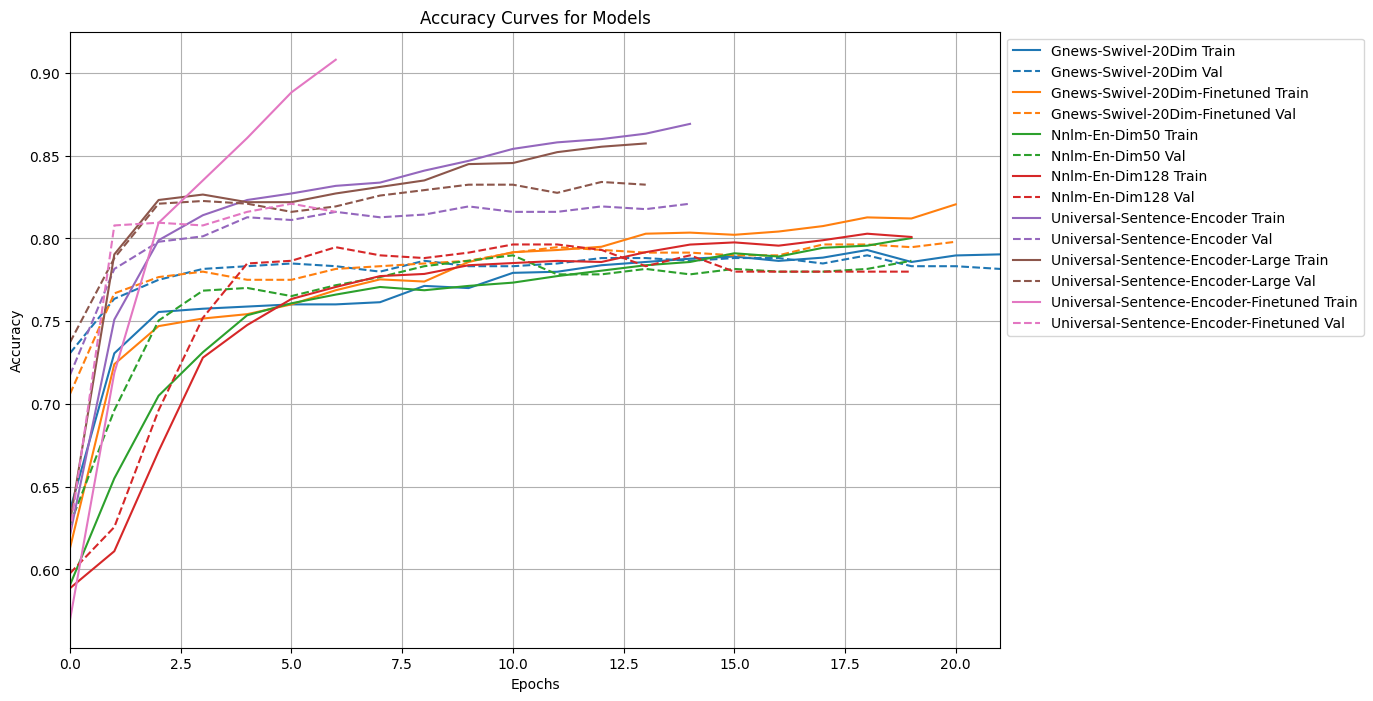

In [18]:
plt.rcParams['figure.figsize'] = (12, 8)
plotter = tfdocs.plots.HistoryPlotter(metric = 'accuracy')
plotter.plot(histories)
plt.xlabel("Epochs")
plt.legend(bbox_to_anchor=(1.0, 1.0), loc='upper left')
plt.title("Accuracy Curves for Models")
plt.show()

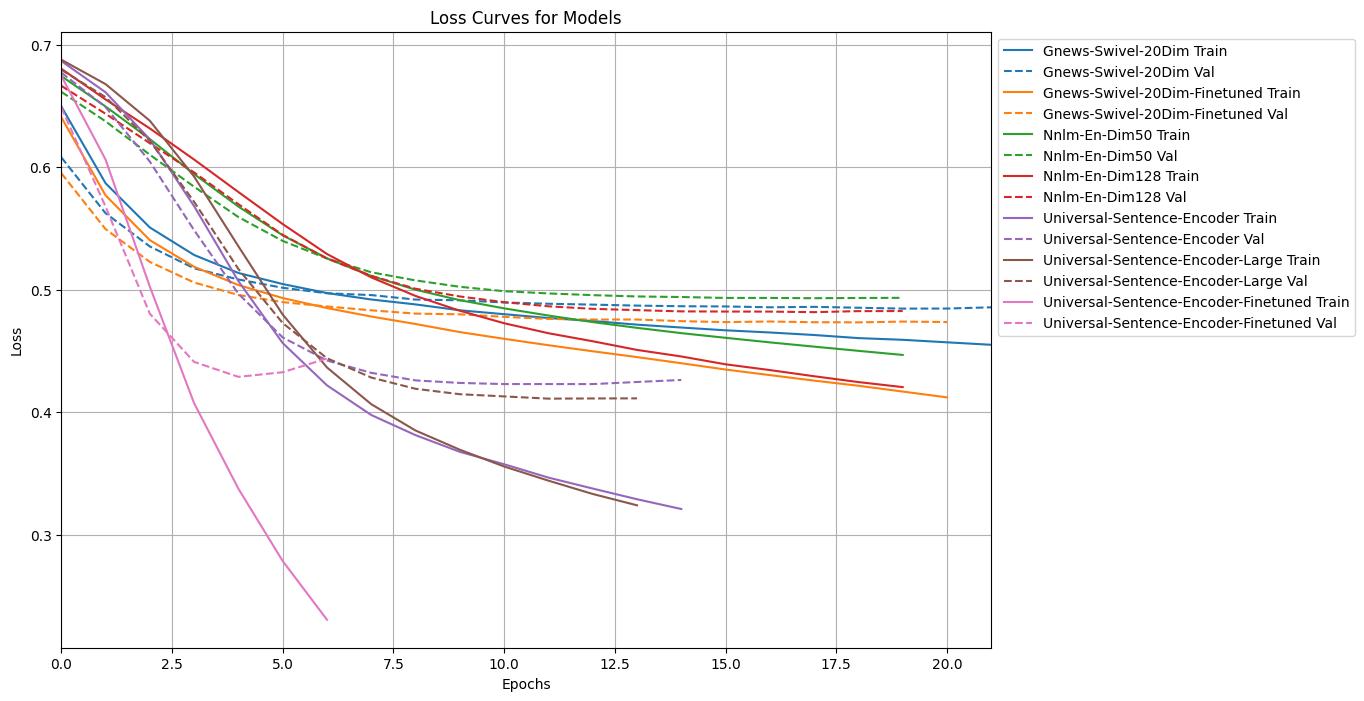

In [19]:
plotter = tfdocs.plots.HistoryPlotter(metric = 'loss')
plotter.plot(histories)
plt.xlabel("Epochs")
plt.legend(bbox_to_anchor=(1.0, 1.0), loc='upper left')
plt.title("Loss Curves for Models")
plt.show()

# Key Findings
The "Universal Sentence Encoder" (fine-tuned) consistently outperformed other models across various performance metrics.
Fine-tuning allowed us to adapt the model to our specific task, resulting in higher accuracy and better generalization.
The performance gain demonstrates the effectiveness of fine-tuning pre-trained models for text classification tasks.

# Conclusion
In this project, we observed that fine-tuning the "Universal Sentence Encoder" led to remarkable improvements in model performance for text classification. This approach showcases the potential of transfer learning and fine-tuning to achieve state-of-the-art results with minimal training data.

The final performance comparison plot provides a clear visual representation of the model's success in outperforming other models, making it a valuable tool for decision-making and model selection.